In [1]:
import h5py, os, cv2
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
cmap = cm.get_cmap("jet")


/tmp/ipykernel_64752/3050200940.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("jet")


In [2]:
def multiclass_vis(class_labels, img_to_viz, num_of_labels, np_used = False,alpha = 0.5):
    _overlay = img_to_viz.astype(float) / 255.0
    if np_used:
         viz = cmap(class_labels/num_of_labels)[..., :3]
    else:
         class_labels = class_labels.detach().cpu().numpy().astype(float)
         viz = cmap((class_labels/num_of_labels))[..., :3]
    _overlay =  alpha * viz + (1-alpha) * _overlay 
    s_overlay = cv2.cvtColor(np.float32(_overlay), cv2.COLOR_BGR2RGB)  

    return _overlay
    
def get_vis_anns(anns,img_to_viz,nbrs=None):
   
    count = 1
    dum = anns[0]['segmentation']
    img = np.zeros((dum.shape[0], dum.shape[1]))
    for ann in anns:
        m = ann['segmentation']
        img[m] = count
        count+=1
    _overlay = multiclass_vis(img, img_to_viz, count, np_used = True)
    if nbrs is not None: # ignore this for now
        _overlay = draw_segment_lines(_overlay, anns, nbrs)
    return _overlay

def showSegFromH5(h5filename,ims,imgIdx,regIdx=None,cfg=None,doPlot=True,dataDir="./"):
    with h5py.File(h5filename,'r') as f:
        if isinstance(ims[0],str):
            imname = ims[imgIdx] 
            im = cv2.imread(f'{dataDir}/{imname}')
            print(im.shape)
        else:
            imname, im = imgIdx, ims[imgIdx]
        key = f"{imname}"
        if regIdx is None:
            masks = [f[key+f'/masks/{k}/'] for k in natsorted(f[key+'/masks/'].keys())]
        else:
            masks = [f[key+f'/masks/{regIdx}/']]
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (cfg['desired_width'],cfg['desired_height']))
        im = get_vis_anns(masks,im.copy())
        if doPlot:
            plt.imshow(im)
            plt.show()
    return im

def print_hdf5_item_info(item, indent=""):
    if isinstance(item, h5py.Group):
        print(f"{indent}Group: {item.name}")
        for subitem_name in item:
            subitem = item[subitem_name]
            print_hdf5_item_info(subitem, indent + "  ")
    elif isinstance(item, h5py.Dataset):
        print(f"{indent}Dataset: {item.name}")
        print(f"{indent}  Datatype: {item.dtype}")
        print(f"{indent}  Shape: {item.shape}")
    else:
        print(f"{indent}Unknown item: {item.name}")

In [3]:
with h5py.File("./data/GP_dl_env_nodes.h5",'r') as f:
    print("Image names as keys",f.keys())
    print("\ndata for one image:")
    print_hdf5_item_info(f['Image000.jpg'])

Image names as keys <KeysViewHDF5 ['Image000.jpg', 'Image001.jpg', 'Image002.jpg', 'Image003.jpg', 'Image004.jpg']>

data for one image:
Group: /Image000.jpg
  Group: /Image000.jpg/masks
    Group: /Image000.jpg/masks/0
      Dataset: /Image000.jpg/masks/0/area
        Datatype: int64
        Shape: ()
      Dataset: /Image000.jpg/masks/0/bbox
        Datatype: int64
        Shape: (4,)
      Dataset: /Image000.jpg/masks/0/crop_box
        Datatype: int64
        Shape: (4,)
      Dataset: /Image000.jpg/masks/0/point_coords
        Datatype: float64
        Shape: (1, 2)
      Dataset: /Image000.jpg/masks/0/predicted_iou
        Datatype: float64
        Shape: ()
      Dataset: /Image000.jpg/masks/0/segmentation
        Datatype: bool
        Shape: (240, 320)
      Dataset: /Image000.jpg/masks/0/stability_score
        Datatype: float64
        Shape: ()
    Group: /Image000.jpg/masks/1
      Dataset: /Image000.jpg/masks/1/area
        Datatype: int64
        Shape: ()
      Dataset:

(540, 960, 3)


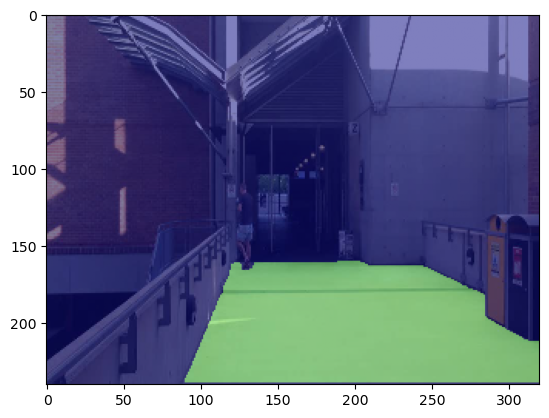

In [4]:
dataDir = "./data/images/"
h5File = "./data/GP_dl_env_nodes.h5"
ims = sorted(os.listdir(dataDir))
cfg = {"desired_width": 320, "desired_height": 240}
# _ = showSegFromH5(h5File,ims,imgIdx=0,regIdx=None,cfg=cfg,dataDir=dataDir)
# _ = showSegFromH5(h5File,ims,imgIdx=1,regIdx=None,cfg=cfg,dataDir=dataDir)
_ = showSegFromH5(h5File,ims,imgIdx=0,regIdx=0,cfg=cfg,dataDir=dataDir)

In [5]:
feats = []
masks_all_imgs = []
regIdx = None
f = h5py.File(h5File,'r')
for imgIdx, imgName in enumerate(ims):
    print(imgIdx, imgName)
    im = cv2.imread(f'{dataDir}/{imgName}')
    key = f"{imgName}"
    feats.append(f[key+f'/rft_clip'])
    
    if regIdx is None:
        masks = [f[key+f'/masks/{k}/'] for k in natsorted(f[key+'/masks/'].keys())]
    else:
        masks = [f[key+f'/masks/{regIdx}/']]
    masks_all_imgs.append(masks)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (cfg['desired_width'],cfg['desired_height']))
    im = get_vis_anns(masks,im.copy())
    if False:
        plt.imshow(im)
        plt.show()
print(feats)

0 Image000.jpg
1 Image001.jpg
2 Image002.jpg
3 Image003.jpg
4 Image004.jpg
[<HDF5 dataset "rft_clip": shape (86, 512), type "<f4">, <HDF5 dataset "rft_clip": shape (69, 512), type "<f4">, <HDF5 dataset "rft_clip": shape (63, 512), type "<f4">, <HDF5 dataset "rft_clip": shape (63, 512), type "<f4">, <HDF5 dataset "rft_clip": shape (72, 512), type "<f4">]


In [7]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
from pathlib import Path
import time

torch.set_grad_enabled(False);
images = Path('data/images/')

In [8]:
# Load extractor and matcher module
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
# use SuperPoint features combined with LightGlue.
matcher = LightGlue(features='superpoint').eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /home/sourav/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 20.6MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/sourav/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv-pth
100%|██████████| 45.3M/45.3M [00:02<00:00, 16.7MB/s]


torch.Size([3, 540, 960])
86
mask.shape (3, 240, 320)
image0_resized.shape torch.Size([3, 240, 320])
mask.shape (3, 240, 320)
image1_resized.shape torch.Size([3, 240, 320])
--- Feature Extraction: 523.7019062042236 milliseconds ---
--- Matching: 14.163017272949219 milliseconds ---
209


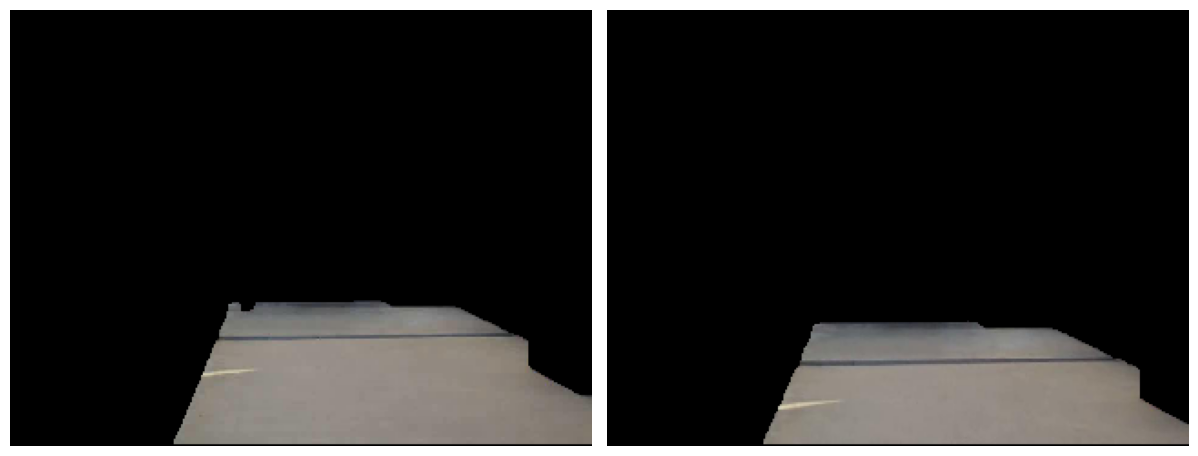

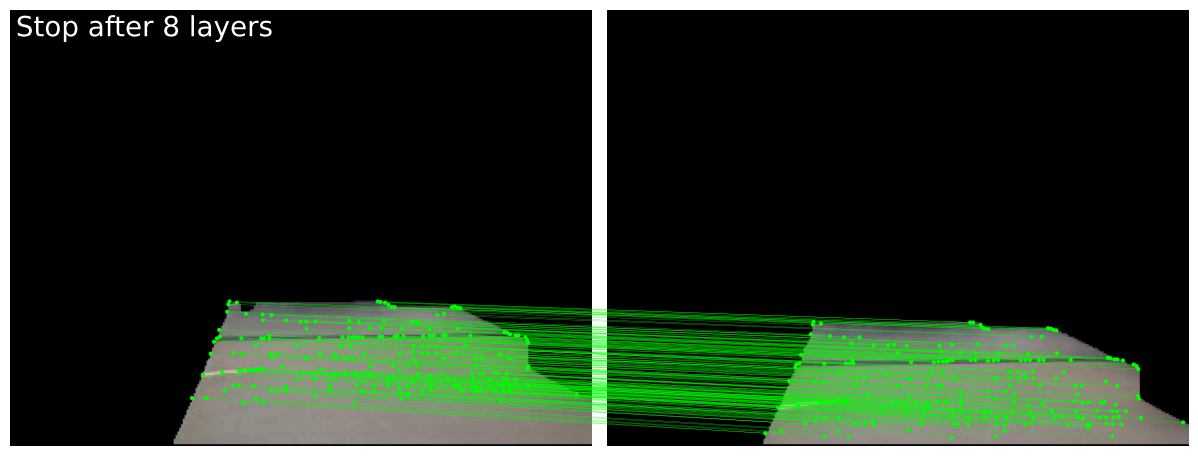

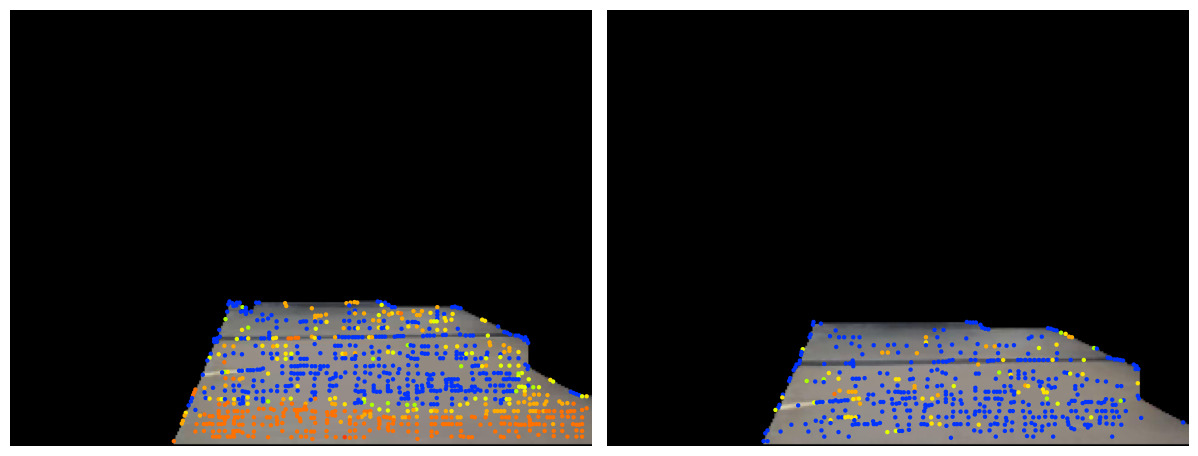

In [9]:
image0 = load_image(images / 'Image000.jpg')
image1 = load_image(images / 'Image001.jpg')

print(image0.shape)
print(len(masks_all_imgs[0]))
mask = np.array(masks_all_imgs[0][0]['segmentation'])
mask = mask.reshape(1, 240, 320).repeat(3, axis=0)
print("mask.shape", mask.shape)
mask = torch.tensor(mask)
image0 = image0.reshape(1, 3, 540, 960)
image0_resized = torch.nn.functional.interpolate(image0, (240, 320))
image0_resized = image0_resized.reshape(3, 240, 320)
print("image0_resized.shape", image0_resized.shape)
image0 = image0_resized * mask
# image0 = image0_resized

mask_1 = np.array(masks_all_imgs[1][0]['segmentation'])
mask_1 = mask_1.reshape(1, 240, 320).repeat(3, axis=0)
print("mask.shape", mask_1.shape)
mask_1 = torch.tensor(mask_1)
image1 = image1.reshape(1, 3, 540, 960)
image1_resized = torch.nn.functional.interpolate(image1, (240, 320))
image1_resized = image1_resized.reshape(3, 240, 320)
print("image1_resized.shape", image1_resized.shape)
image1 = image1_resized * mask_1
# image1 = image1_resized

# viz2d.plot_images([image0.reshape(3, 540, 960), image1])
# viz2d.plot_images([image0_resized, image1])
# viz2d.plot_images([image0_resized, image1_resized])
viz2d.plot_images([image0, image1])
start_time = time.time()
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
print(f"--- Feature Extraction: {(time.time() - start_time) * 1000} milliseconds ---")
start_time = time.time()
# feats0 = extractor.extract(image0.to(device) *  mask.to(device))
# feats1 = extractor.extract(image1.to(device) *  mask_1.to(device))
# feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
print(f"--- Matching: {(time.time() - start_time) * 1000} milliseconds ---")
kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
print(matches.shape[0])

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)